In [2]:
from AutoEncoderModel import AutoEncoderHPyloris
from classifierBalancedDataset import HPylorisDatasetClassifier
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc

In [2]:
def predict_patch(model, image, transform, inverse_transform, threshold=0.25, device='cpu'):
    """
    Inputs:
        MODEL: AutoEncoder model, given an input image, returns the reconstructed image
        IMAGE: a 3 channel image that will be reconstructed
        TRANSFORM: transforms that will be applied to input image
        INVERSE_TRANSFORM: transforms that will be applied to reconstructed image
        THRESHOLD (default=0.25): the threshold that will classify the patch
        DEVICE (default='cpu'): device where the model will be loaded (cpu or cuda)
    Outputs:
        INFECTION: 0 if no infection, 1 if infection
    """
    
    with torch.no_grad():
        original = transform(image).to(device).unsqueeze(0)
        reconstructed_image = inverse_transform(model(original).squeeze(0))

        hsv_original_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
        red_pixels_original = np.sum(np.logical_or((hsv_original_image[:, :, 0] < 20) & (hsv_original_image[:, :, 0] >= 0),
                                            (hsv_original_image[:, :, 0] > 160) & (hsv_original_image[:, :, 0] <= 180)))
        percentage_original = 100 * (red_pixels_original / (224 * 224))
        
        hsv_reconstructed_image = cv2.cvtColor(np.array(reconstructed_image), cv2.COLOR_RGB2HSV)
        red_pixels_reconstructed = np.sum(np.logical_or((hsv_reconstructed_image[:, :, 0] < 20) & (hsv_reconstructed_image[:, :, 0] >= 0), 
                                                        (hsv_reconstructed_image[:, :, 0] > 160) & (hsv_reconstructed_image[:, :, 0] <= 180)))
        percentage_reconstructed = 100 * (red_pixels_reconstructed / (224 * 224))
        
        lost_pixels_ratio = percentage_original-percentage_reconstructed if percentage_reconstructed != 0 else 0
        
        if lost_pixels_ratio >= threshold:
            return 1
        else:
            return 0

In [3]:
model_path = '/fhome/gia01/vl_project2/autoencoder/model_pkl/10_EPOCH_MSE_AE.pkl'
with open(model_path, 'rb') as weights:
    state = pickle.load(weights)
    model = AutoEncoderHPyloris()
    model.load_state_dict(state)        

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device); model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                                                std=[1/0.229, 1/0.224, 1/0.225]), 
                                        transforms.ToPILImage()])

In [5]:
labels_path = '/fhome/mapsiv/QuironHelico/AnnotatedPatches/window_metadata.csv'
image_folders_path = '/fhome/mapsiv/QuironHelico/AnnotatedPatches/'

specifyPatientsPathTrain = '/fhome/gia01/vl_project2/randomDatasetCNN.txt'
specifyPatientsPathTest = '/fhome/gia01/vl_project2/randomDatasetVGG.txt'

myDatasetTrain = HPylorisDatasetClassifier(data_folder=image_folders_path, 
                                           annotations=None,
                                           specifyPaths=specifyPatientsPathTrain)

myDatasetTest = HPylorisDatasetClassifier(data_folder=image_folders_path, 
                                          annotations=None,
                                          specifyPaths=specifyPatientsPathTest)

len(myDatasetTrain)

162

In [6]:
thresholds = [0.0, 0.01, 0.05, 0.15, 0.20, 0.25, 0.30, 0.35, 0.50, 0.70, 1.00, 1.50, 2.00, 3.00, 5.00, 10.00, 50.00]
predictions = []
gt = []

In [7]:
for threshold in thresholds:
    pred = []
    for idx in range(len(myDatasetTrain)):
        image, label = myDatasetTrain[idx]
        
        if len(predictions)==0:
            gt.append(label)
            
        pred.append(predict_patch(model, image, 
                                    transform, inverse_transform,
                                    threshold=threshold, device=device))
    predictions.append(pred)

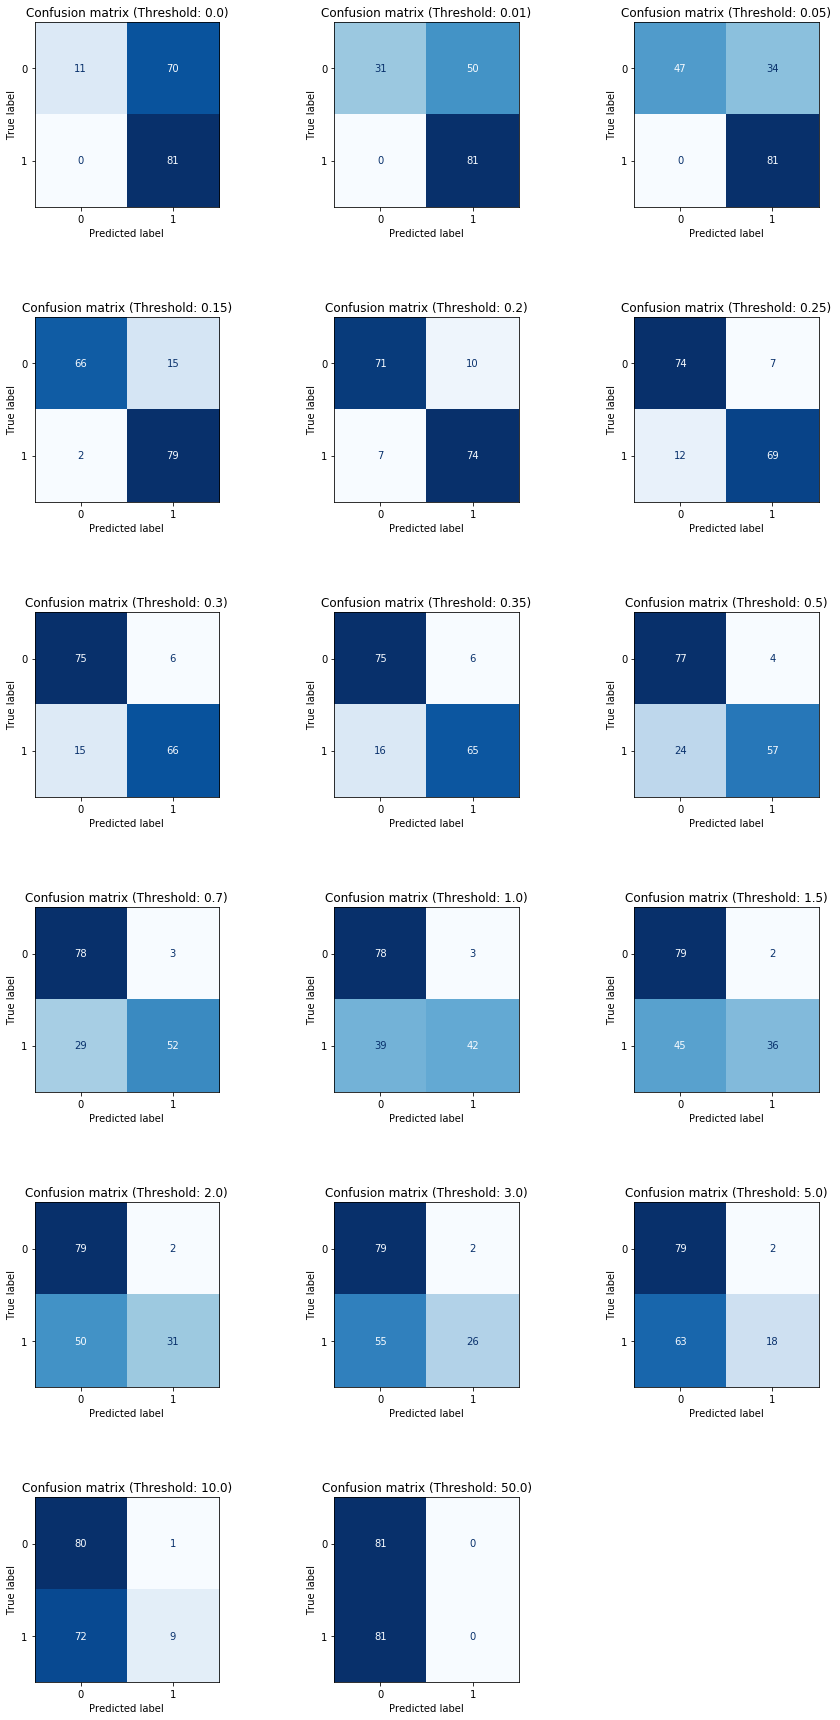

In [8]:
# In order to store the true negative, false positive, false negative and true positive
ravels = list()

# Set the number of subplots based on the number of thresholds
n_cols = 3
n_rows = int(np.ceil(len(thresholds) / n_cols))

# Create a figure to hold all the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the thresholds and plot each confusion matrix
for i, threshold in enumerate(thresholds):
    # Compute confusion matrix
    cm = confusion_matrix(gt, predictions[i])
    # Unpack the confusion matrix into true negative, false positive, false negative and true positive
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    # Store the ravel in a list
    ravel = [true_neg, false_pos, false_neg, true_pos]
    ravels.append(ravel)
    
    # Initialize the display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])

    # Plot in the next subplot
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion matrix (Threshold: {threshold})')

# Hide any unused subplots
for ax in axes[len(thresholds):]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add more space between the plots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.savefig('autoencoder_confusion_matrix.png')
plt.show()

The accuracy of the model with a threshold of 0.0 is 0.57
The area under the ROC curve (AUC) for threshold 0.0 is 0.57

The accuracy of the model with a threshold of 0.01 is 0.69
The area under the ROC curve (AUC) for threshold 0.01 is 0.69

The accuracy of the model with a threshold of 0.05 is 0.79
The area under the ROC curve (AUC) for threshold 0.05 is 0.79

The accuracy of the model with a threshold of 0.15 is 0.90
The area under the ROC curve (AUC) for threshold 0.15 is 0.90

The accuracy of the model with a threshold of 0.2 is 0.90
The area under the ROC curve (AUC) for threshold 0.2 is 0.90

The accuracy of the model with a threshold of 0.25 is 0.88
The area under the ROC curve (AUC) for threshold 0.25 is 0.88

The accuracy of the model with a threshold of 0.3 is 0.87
The area under the ROC curve (AUC) for threshold 0.3 is 0.87

The accuracy of the model with a threshold of 0.35 is 0.86
The area under the ROC curve (AUC) for threshold 0.35 is 0.86

The accuracy of the model with

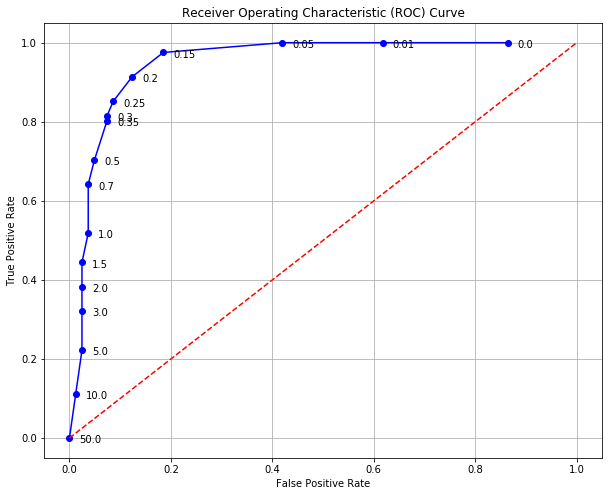

In [9]:
# Lists to hold all TPRs and FPRs
TPRs = []
FPRs = []
AUCs = []

# Iterate over each threshold and corresponding confusion matrix ravel to calculate TPR and FPR
for i, threshold in enumerate(thresholds):
    true_neg, false_pos, false_neg, true_pos = ravels[i]

    # Calculate TPR and FPR
    TPR = true_pos / (true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
    FPR = false_pos / (false_pos + true_neg) if (false_pos + true_neg) != 0 else 0

    TPRs.append(TPR)
    FPRs.append(FPR)

    # Calculate AUC for ROC curve
    AUC = auc([0, FPR, 1], [0, TPR, 1])
    AUCs.append(AUC)

    print(f"The accuracy of the model with a threshold of {threshold} is {(true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg):.2f}")
    print(f"The area under the ROC curve (AUC) for threshold {threshold} is {AUC:.2f}")
    print()

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(FPRs, TPRs, marker='o', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Random chance line

# Annotate each point on the ROC curve with its threshold
for i, threshold in enumerate(thresholds):
    plt.annotate(threshold, (FPRs[i], TPRs[i]), textcoords="offset points", xytext=(10,-5))

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.savefig('autoencoder_roc_curve.png')
plt.show()

In [10]:
pred = []
gt = []
for idx in range(len(myDatasetTest)):
    image, label = myDatasetTest[idx]
    pred.append(predict_patch(model, image, 
                              transform, inverse_transform,
                              threshold=0.20, device=device))
    gt.append(label)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(gt, pred)

print("Test Classification Report:")
print(classification_report(gt, pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        82
           1       0.81      0.93      0.86        82

    accuracy                           0.85       164
   macro avg       0.86      0.85      0.85       164
weighted avg       0.86      0.85      0.85       164



AQUIIIII

In [3]:
# Initialize the dictionary to store the data
data_dict = {'INFECTED': {}, 'NOT_INFECTED': {}}

# Read the file line by line
with open('/fhome/gia01/vl_project2/autoencoder/txt files/train_thresholds.txt', 'r') as file:
    for line in file:
        # Strip any whitespace and split the line by comma
        parts = line.strip().split(',')
        # Assign the parts to variables for clarity
        sample_id, path, status = parts[0], parts[1], int(parts[2])
        # Depending on the status, add the entry to the respective dictionary key
        if status == 1:
            data_dict['INFECTED'][sample_id] = path
        else:
            data_dict['NOT_INFECTED'][sample_id] = path

# Now data_dict is populated with the data in the format you wanted.
print(data_dict)

{'INFECTED': {'B22-65': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-65_1/', 'B22-222': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-222_1/', 'B22-130': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-130_1/', 'B22-225': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-225_1/', 'B22-263': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-263_1/', 'B22-39': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-39_1/', 'B22-169': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-169_1/', 'B22-75': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-75_1/', 'B22-49': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-49_1/', 'B22-82': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-82_1/', 'B22-159': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-159_1/', 'B22-96': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-96_1/', 'B22-255': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-255_1/', 'B22-310': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-310_1/', 'B22-105': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-10

In [4]:
# Declaration of the function in order to make the conversion
def calculate_confidence(percentage, threshold):
    """
    Calculate the confidence level based on a given percentage using a rule of three.

    Parameters:
    percentage (float): A percentage value where 0.1 maps to a confidence level of 1.

    Returns:
    float: The calculated confidence level, capped at 1 for percentages over 0.1.
    """
    # If the percentage is greater than 0.1, the confidence is 1
    if percentage >= threshold:
        return 1
    else:
        # Otherwise, scale the confidence linearly from 0 to 1 as the percentage goes from 0 to 0.1
        # Using the rule of three: percentage / 0.1 = confidence / 1
        confidence = percentage / threshold
        return confidence

In [5]:
def predict_patch(model, image, transform, inverse_transform, threshold=0.25, device='cpu'):
    """
    Inputs:
        MODEL: AutoEncoder model, given an input image, returns the reconstructed image
        IMAGE: a 3 channel image that will be reconstructed
        TRANSFORM: transforms that will be applied to input image
        INVERSE_TRANSFORM: transforms that will be applied to reconstructed image
        THRESHOLD (default=0.25): the threshold that will classify the patch
        DEVICE (default='cpu'): device where the model will be loaded (cpu or cuda)
    Outputs:
        INFECTION: 0 if no infection, 1 if infection
    """

    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Apply the transformations to convert the PIL image to a PyTorch tensor
    image_tensor = transform(image).unsqueeze(0)
    
    # Move the tensor to the specified device
    image_tensor = image_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        model.to(device)
        #original = transform(image).unsqueeze(0)
        #original.to(device)
        reconstructed_image = inverse_transform(model(image_tensor).squeeze(0))

        hsv_original_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
        red_pixels_original = np.sum(np.logical_or((hsv_original_image[:, :, 0] < 20) & (hsv_original_image[:, :, 0] >= 0),
                                            (hsv_original_image[:, :, 0] > 160) & (hsv_original_image[:, :, 0] <= 180)))
        percentage_original = 100 * (red_pixels_original / (224 * 224))
        
        hsv_reconstructed_image = cv2.cvtColor(np.array(reconstructed_image), cv2.COLOR_RGB2HSV)
        red_pixels_reconstructed = np.sum(np.logical_or((hsv_reconstructed_image[:, :, 0] < 20) & (hsv_reconstructed_image[:, :, 0] >= 0), 
                                                        (hsv_reconstructed_image[:, :, 0] > 160) & (hsv_reconstructed_image[:, :, 0] <= 180)))
        percentage_reconstructed = 100 * (red_pixels_reconstructed / (224 * 224))
        
        lost_pixels_ratio = percentage_original-percentage_reconstructed if percentage_reconstructed != 0 else 0
        
        if lost_pixels_ratio >= threshold:
            return 1
        else:
            return 0

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/fhome/gia01/vl_project2/autoencoder/model_pkl/10_EPOCH_MSE_AE.pkl'
with open(model_path, 'rb') as weights:
    state = pickle.load(weights)
    model = AutoEncoderHPyloris()
    model.load_state_dict(state)        

In [7]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                                                std=[1/0.229, 1/0.224, 1/0.225]), 
                                        transforms.ToPILImage()])

In [8]:
import os
from PIL import Image

y_scores001 = list() # Store the probability estimates of being from the infected class, threshold: %1
y_scores002 = list() # Store the probability estimates of being from the infected class, threshold: %2
y_scores0025 = list() # Store the probability estimates of being from the infected class, threshold: %2.5
y_scores003 = list() # Store the probability estimates of being from the infected class, threshold: %3
y_scores0035 = list() # Store the probability estimates of being from the infected class, threshold: %3.5
y_scores004 = list() # Store the probability estimates of being from the infected class, threshold: %4
y_scores005 = list() # Store the probability estimates of being from the infected class, threshold: %5
y_scores007 = list() # Store the probability estimates of being from the infected class, threshold: %7
y_scores015 = list() # Store the probability estimates of being from the infected class, threshold: %15
y_scores050 = list() # Store the probability estimates of being from the infected class, threshold: %50
y_scores075 = list() # Store the probability estimates of being from the infected class, threshold: %75
y_scores090 = list() # Store the probability estimates of being from the infected class, threshold: %90

infectedPer_list = list() # Store the infected percentage for each patient

y_test = list() # Store the ground truth from the data, infected or not infected

# Iterate over the test set
for label in data_dict:

    patients_dict = data_dict[label] # Get the dictionary of the patients

    # Determine ground truth
    if (label == "INFECTED"): # Infected
        gt = 1
    
    else: # Not infected
        gt = 0

    
    i = 0 # Counter    
    # Iterate over the patients
    for patient in patients_dict:
        patient_predictions = list() # Initialize the data structure in which the prediction for a particular patient will be stored
        # Get a list of all the full paths for the images from the patient
        images_files_full_paths = [os.path.join(patients_dict[patient], file) for file in os.listdir(patients_dict[patient])]

        """
        if __name__ == '__main__':

            with Pool() as p:
                # Use the map function to distribute the work among the worker processes
                patient_predictions = p.map(process_patient, images_files_full_paths)
        """
        
        # Iterate over all the images of the patient
        for image_path in images_files_full_paths:

            imageAE = Image.open(image_path) # Open image with PIL
            predAE = predict_patch(model, imageAE, transform, inverse_transform = inverse_transform, threshold=0.25, device=device) # Get the prediction for the patch
            patient_predictions.append(predAE) # Append the prediction

        value = 1 # Infected class

        # Calculate the percentage of infected detected patches for a particular patient
        infected_percentage = patient_predictions.count(value) / len(patient_predictions)

        infectedPer_list.append(infected_percentage)

        # Calculate the estimated probability of the model based on predefined criterion for the diagnosis
        # += threshold of infected patches in a patient - estimated probability of infection: 100%
        # 0% of infected patches in a patient - estimated probability of infection: 0%
        y_score001 = calculate_confidence(infected_percentage, 0.01) # Threshold: %1
        y_score002 = calculate_confidence(infected_percentage, 0.02) # Threshold: %2
        y_score0025 = calculate_confidence(infected_percentage, 0.025) # Threshold: %2.5
        y_score003 = calculate_confidence(infected_percentage, 0.03) # Threshold: %3
        y_score0035 = calculate_confidence(infected_percentage, 0.035) # Threshold: %3.5
        y_score004 = calculate_confidence(infected_percentage, 0.04) # Threshold: %4
        y_score005 = calculate_confidence(infected_percentage, 0.05) # Threshold: %5
        y_score007 = calculate_confidence(infected_percentage, 0.07) # Threshold: %7
        y_score015 = calculate_confidence(infected_percentage, 0.15) # Threshold: %15
        y_score050 = calculate_confidence(infected_percentage, 0.50) # Threshold: %50
        y_score075 = calculate_confidence(infected_percentage, 0.75) # Threshold: %75
        y_score090 = calculate_confidence(infected_percentage, 0.90) # Threshold: %90
        
        # Update y_score and y_test lists
        y_scores001.append(y_score001)
        y_scores002.append(y_score002)
        y_scores0025.append(y_score0025)
        y_scores003.append(y_score003)
        y_scores0035.append(y_score0035)
        y_scores004.append(y_score004)
        y_scores005.append(y_score005)
        y_scores007.append(y_score007)
        y_scores015.append(y_score015)
        y_scores050.append(y_score050)
        y_scores075.append(y_score075)
        y_scores090.append(y_score090)

        y_test.append(gt) # Ground truth

        i += 1
        print("Patient", str(i) + ":", "for 0.01  |", gt, "-", round(y_score001, 3))
        print("Patient", str(i) + ":", "for 0.02  |", gt, "-", round(y_score002, 3))
        print("Patient", str(i) + ":", "for 0.025 |", gt, "-", round(y_score0025, 3))
        print("Patient", str(i) + ":", "for 0.03  |", gt, "-", round(y_score003, 3))
        print("Patient", str(i) + ":", "for 0.035 |", gt, "-", round(y_score0035, 3))
        print("Patient", str(i) + ":", "for 0.04  |", gt, "-", round(y_score004, 3))
        print("Patient", str(i) + ":", "for 0.05  |", gt, "-", round(y_score005, 3))
        print("Patient", str(i) + ":", "for 0.07  |", gt, "-", round(y_score007, 3))
        print("Patient", str(i) + ":", "for 0.15  |", gt, "-", round(y_score015, 3))
        print("Patient", str(i) + ":", "for 0.50  |", gt, "-", round(y_score050, 3))
        print("Patient", str(i) + ":", "for 0.75  |", gt, "-", round(y_score075, 3))
        print("Patient", str(i) + ":", "for 0.90  |", gt, "-", round(y_score090, 3))
        print()

        # print(y_scores) # Display scores
        # print(y_test) # Display ground truth

        # Update control data structure
        # CNN_predictions.append((str(patient), [gt, y_score]))

Patient 1: for 0.01  | 1 - 1
Patient 1: for 0.02  | 1 - 1
Patient 1: for 0.025 | 1 - 1
Patient 1: for 0.03  | 1 - 1
Patient 1: for 0.035 | 1 - 1
Patient 1: for 0.04  | 1 - 1
Patient 1: for 0.05  | 1 - 1
Patient 1: for 0.07  | 1 - 1
Patient 1: for 0.15  | 1 - 1
Patient 1: for 0.50  | 1 - 0.672
Patient 1: for 0.75  | 1 - 0.448
Patient 1: for 0.90  | 1 - 0.374

Patient 2: for 0.01  | 1 - 1
Patient 2: for 0.02  | 1 - 1
Patient 2: for 0.025 | 1 - 1
Patient 2: for 0.03  | 1 - 1
Patient 2: for 0.035 | 1 - 1
Patient 2: for 0.04  | 1 - 1
Patient 2: for 0.05  | 1 - 1
Patient 2: for 0.07  | 1 - 1
Patient 2: for 0.15  | 1 - 1
Patient 2: for 0.50  | 1 - 0.409
Patient 2: for 0.75  | 1 - 0.273
Patient 2: for 0.90  | 1 - 0.227

Patient 3: for 0.01  | 1 - 1
Patient 3: for 0.02  | 1 - 1
Patient 3: for 0.025 | 1 - 1
Patient 3: for 0.03  | 1 - 1
Patient 3: for 0.035 | 1 - 1
Patient 3: for 0.04  | 1 - 1
Patient 3: for 0.05  | 1 - 1
Patient 3: for 0.07  | 1 - 1
Patient 3: for 0.15  | 1 - 1
Patient 3: for 0.

In [9]:
binary_labels001 = [1 if prob >= 0.5 else 0 for prob in y_scores001] # Threshold: %1
binary_labels002 = [1 if prob >= 0.5 else 0 for prob in y_scores002] # Threshold: %2
binary_labels0025 = [1 if prob >= 0.5 else 0 for prob in y_scores0025] # Threshold: %2.5
binary_labels003 = [1 if prob >= 0.5 else 0 for prob in y_scores003] # Threshold: %3
binary_labels0035 = [1 if prob >= 0.5 else 0 for prob in y_scores0035] # Threshold: %3.5
binary_labels004 = [1 if prob >= 0.5 else 0 for prob in y_scores004] # Threshold: %4
binary_labels005 = [1 if prob >= 0.5 else 0 for prob in y_scores005] # Threshold: %5
binary_labels007 = [1 if prob >= 0.5 else 0 for prob in y_scores007] # Threshold: %7
binary_labels015 = [1 if prob >= 0.5 else 0 for prob in y_scores015] # Threshold: %15
binary_labels050 = [1 if prob >= 0.5 else 0 for prob in y_scores050] # Threshold: %50
binary_labels075 = [1 if prob >= 0.5 else 0 for prob in y_scores075] # Threshold: %75
binary_labels090 = [1 if prob >= 0.5 else 0 for prob in y_scores090] # Threshold: %90

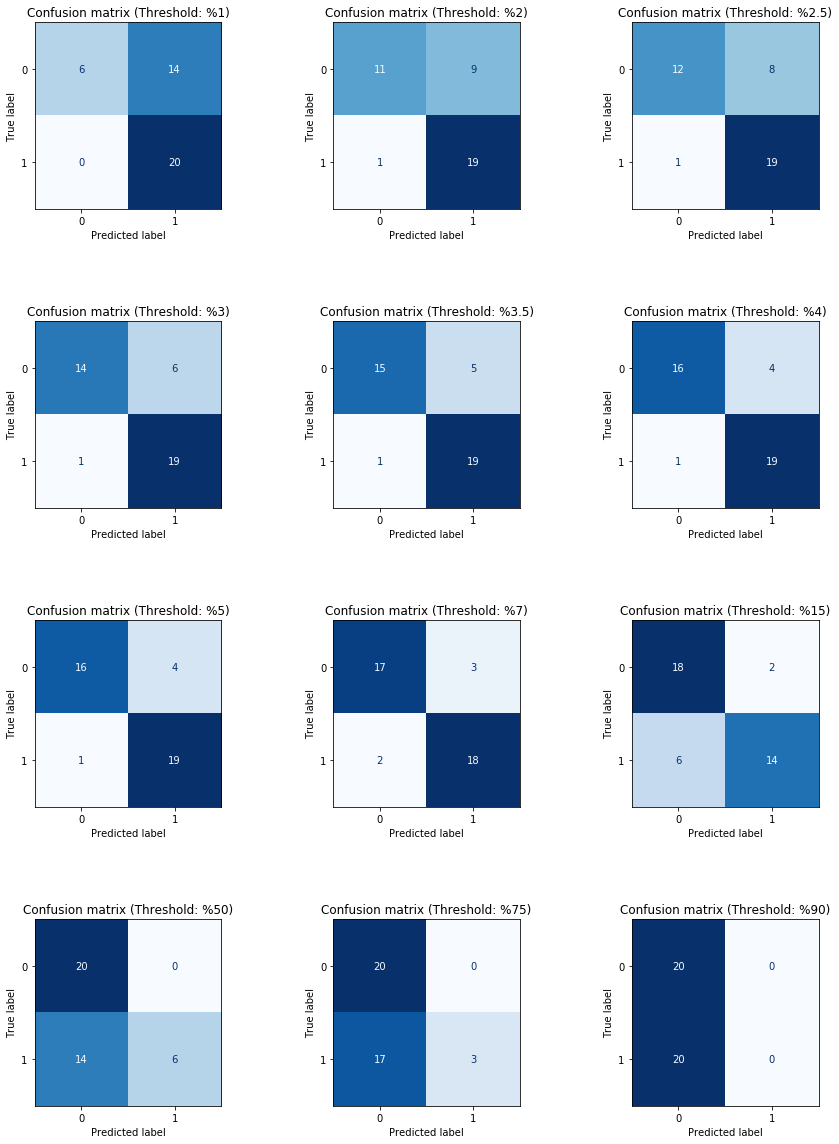

In [10]:
# Assuming you have binary_labels0025, binary_labels0035, binary_labels004, binary_labels005, etc. already defined
# Define the thresholds for each binary label
thresholds = ['%1', '%2', '%2.5', '%3', '%3.5', '%4', '%5', '%7', '%15', '%50', '%75', '%90']
# Store all the binary labels in a list
binary_labels_list = [binary_labels001, binary_labels002, binary_labels0025, binary_labels003, binary_labels0035, binary_labels004, binary_labels005, binary_labels007, binary_labels015, binary_labels050, binary_labels075, binary_labels090]
# In order to store the true negative, false positive, false negative and true positive
ravels = list()

# Set the number of subplots based on the number of thresholds
n_cols = 3
n_rows = int(np.ceil(len(thresholds) / n_cols))

# Create a figure to hold all the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the thresholds and plot each confusion matrix
for i, threshold in enumerate(thresholds):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, binary_labels_list[i])
    # Unpack the confusion matrix into true negative, false positive, false negative and true positive
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    # Store the ravel in a list
    ravel = [true_neg, false_pos, false_neg, true_pos]
    ravels.append(ravel)
    
    # Initialize the display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])

    # Plot in the next subplot
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion matrix (Threshold: {threshold})')

# Hide any unused subplots
for ax in axes[len(thresholds):]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add more space between the plots
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.savefig('autoencoder_confusion_matrix_PATIENT.png')
# Show the plot
plt.show()

The accuracy of the model with a threshold of %1 is 0.65
The area under the ROC curve (AUC) for threshold %1 is 0.65

The accuracy of the model with a threshold of %2 is 0.75
The area under the ROC curve (AUC) for threshold %2 is 0.75

The accuracy of the model with a threshold of %2.5 is 0.78
The area under the ROC curve (AUC) for threshold %2.5 is 0.77

The accuracy of the model with a threshold of %3 is 0.82
The area under the ROC curve (AUC) for threshold %3 is 0.82

The accuracy of the model with a threshold of %3.5 is 0.85
The area under the ROC curve (AUC) for threshold %3.5 is 0.85

The accuracy of the model with a threshold of %4 is 0.88
The area under the ROC curve (AUC) for threshold %4 is 0.88

The accuracy of the model with a threshold of %5 is 0.88
The area under the ROC curve (AUC) for threshold %5 is 0.88

The accuracy of the model with a threshold of %7 is 0.88
The area under the ROC curve (AUC) for threshold %7 is 0.88

The accuracy of the model with a threshold of %1

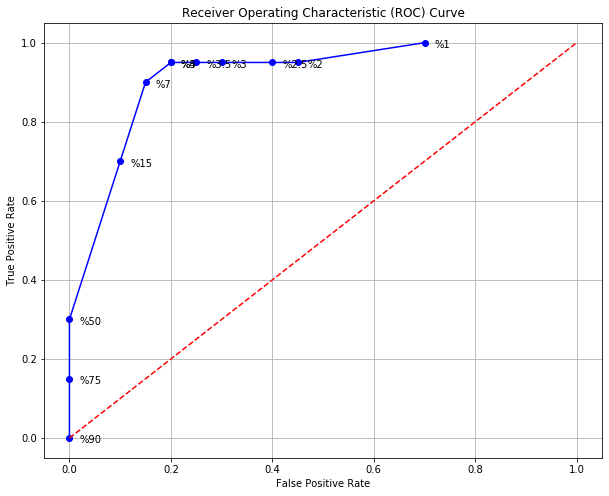

In [11]:
# Lists to hold all TPRs and FPRs
TPRs = []
FPRs = []
AUCs = []

# Iterate over each threshold and corresponding confusion matrix ravel to calculate TPR and FPR
for i, threshold in enumerate(thresholds):
    true_neg, false_pos, false_neg, true_pos = ravels[i]

    # Calculate TPR and FPR
    TPR = true_pos / (true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
    FPR = false_pos / (false_pos + true_neg) if (false_pos + true_neg) != 0 else 0

    TPRs.append(TPR)
    FPRs.append(FPR)

    # Calculate AUC for ROC curve
    AUC = auc([0, FPR, 1], [0, TPR, 1])
    AUCs.append(AUC)

    print(f"The accuracy of the model with a threshold of {threshold} is {(true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg):.2f}")
    print(f"The area under the ROC curve (AUC) for threshold {threshold} is {AUC:.2f}")
    print()

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(FPRs, TPRs, marker='o', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Random chance line

# Annotate each point on the ROC curve with its threshold
for i, threshold in enumerate(thresholds):
    plt.annotate(threshold, (FPRs[i], TPRs[i]), textcoords="offset points", xytext=(10,-5))

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.savefig('autoencoder_roc_curve_PATIENT.png')
plt.show()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print("Test Classification Report:")
print(classification_report(y_test, binary_labels007))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.86      0.90      0.88        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40

